# Yosemite Rockfall Analysis
As a frequenter of Yosemite National Park, I often hear or read about rockfall in the park. The most notable example of rockfall in Yosemite in recent years took place in September 2017, when around 30,000 tons of rock the size of a 12-story apartment building fell off of El Capitan, one of the most iconic cliffs in the park. The rockfall took place over two days and sadly this resulted in the death of an unlucky person hiking at the base of the wall: https://www.latimes.com/local/lanow/la-me-yosemite-rockfall-20170930-story.html.

Despite the frequency with which I hear about rockfall and given the number of climbers on the walls and hikers near the walls during most of the year, I am actually surprised that there are not more deaths and injuries; the last rockfall related death (non-climbing triggered, such as pulling off a hold) was in 1999 (https://www.rei.com/blog/climb/the-surprising-frequency-of-rockfall-in-yosemite-national-park), despite the fact that the annual number of visitors has reached over 1 million every year since 1956 (https://irma.nps.gov/Stats/Reports/Park/YOSE). 

So why is it that deaths from rockfall are not more commonplace? Some possible explanations that come to mind are: maybe rock-fall events primarily occur during less busy times such as over the winter due to heavy snowfall/extreme freeze-thaw cycles. Or maybe rock-fall is just not as frequent or severe as it seems, and events like the one on El Captian in September 2017 are relatively rare.

As a climber myself, I also have a practical interest in knowing which formations feature the most common rock-fall, so I can make an informed decision about the risk associated with climbing them. Anecdotally, Half Dome and the Glacier Point Apron are the two formations I hear the most about concerning rockfall. But is it just large-scale events that lead me to believe these formations are more prone to rock-fall than the less iconic formations, or do the data actually support this?

## The data

These questions can now be tackled quantitatively and with statistical power thanks to a public database of all recorded rockfall events in Yosemite National Park over the years 1857-2011: [https://pubs.usgs.gov/ds/746/](https://pubs.usgs.gov/ds/746/). The database was fastidiously compiled and made public by the United States Geological Survey (USGS), the Department of the Interior, and the National Park Service (NPS). An update to the database to include more recent years is currently in process (G. Stock, private communication).

As we will see, the database consists of around 1000 rockfall events and catalogs their date, time, the rock formation on which they took place, volume of rockfall, as well as some more detailed geological measurements and, in some cases, eye witness accounts. Here I will focus on the date and location of the events to attempt to answer the following questions:


**1) Where does rock-fall most commonly take place in the park? On what formations? **

**2) Are any formations experiencing significant increases or decreases in rockfall activity in the last 10 years (of the available data)? **

**3) Does rock-fall take place preferentially in some seasons? **

## Analyzing the dataset with pandas (python)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
home_dir = './'
data_dir = home_dir + '../data'
csv_file = data_dir + '/Yosemite_rock_fall_database_1857-2011_Master.csv' # the CSV file containing the database entries 
visitors_csv_file = data_dir + '/visitors.csv' # from https://irma.nps.gov/Stats/Reports/Park/YOSE
visitors_montly_csv_file = data_dir + '/visitors_monthly.csv' # from https://irma.nps.gov/Stats/Reports/Park/YOSE

In [11]:
# Load the CSV into a pandas dataframe
df = pd.read_csv(csv_file)

In [12]:
# Quick summary of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 925 entries, 0 to 924
Data columns (total 23 columns):
ID 2011                                                   925 non-null int64
ID 2004                                                   519 non-null float64
ID 1992                                                   394 non-null object
General location                                          925 non-null object
Additional location information                           925 non-null object
Figure location reference (see figs. 1 and 3, table 1)    925 non-null object
Type of slope movement                                    925 non-null object
Season                                                    925 non-null object
Year                                                      925 non-null object
Month                                                     925 non-null object
Day                                                       925 non-null object
Time (PST)                           



Let's first get an idea of how the data are distributed in time, using the 'Year' column:

In [13]:
years = df['Year']
years.head(25)

0          1857
1          1858
2          1860
3          1864
4     1868, pre
5          1870
6          1870
7          1872
8          1872
9          1872
10         1872
11         1872
12         1872
13         1873
14         1873
15         1886
16         1886
17         1886
18         1886
19    1886-1905
20    1886-1905
21         1892
22         1892
23         1892
24         1897
Name: Year, dtype: object

Already we see two different issues: The year column is not always a number, as in row 4 and rows 19,20. So we need to do some cleaning of the data set.

## Cleaning the data frame

In [14]:
# Let's print out all entries where the year is not purely a number:
[year for year in years if filter(str.isdigit,year)!=year]

['1868, pre',
 '1886-1905',
 '1886-1905',
 '1898-99',
 '1915-1916',
 '1918?',
 '1924-1925',
 '1924-1925',
 '1931-32',
 '1931-32',
 '1932-33',
 '1932-33',
 '1932-33',
 '1936-37',
 '1938-39',
 '1939-40',
 '1939-40',
 '1947-48',
 '1951-52',
 '1951-52',
 '1953-54',
 '1967-68',
 '1970-71',
 '1971?',
 '1976-77',
 '1982?',
 '1982-1983',
 '1987-1989',
 '1991-1992',
 '1995-1996',
 '1996-1997',
 '1996-1997',
 '1996-1997',
 '1996-1997',
 '1996-1997',
 '1996-1997',
 '1996-1997',
 '1996-1997',
 '1998-1999',
 '2003-2004',
 '2005-2006']

There are 3 types of problems here:
1. entries with a comma
2. entries that span two years and
3. entries with a "?"

The single entry with a comma seems to indicate that the rockfall event took place before 1868. Since this is only one event and the year is uncertain, let's exclude this row from the database

There are many (37) entries that span two years, and these indicate rockfall events where the exact date of the event  is uncertain. For example, perhaps someone noticed in the spring that a rockfall event had taken place over the winter between 1996 and 1997. We want to remove these as well because we want the exact date of events. A different analysis could perhaps draw dates from a uniform distribution in the range given if the data were needed but their exact dates were not necessary.

There are only 3 entires with a "?" and I assume they represent guesses so let's remove them as well.

In [15]:
years_filtered = np.array([filter(str.isdigit,year) for year in years])
df = df[years==years_filtered]
print "Cleaned database consists of %i rockfall events" % len(df)

Cleaned database consists of 884 rockfall events


In [16]:
# Finally, we need to convert the data type of the year column from string to integer so we can make a histogram and 
# perform follow-up analysis
years = df['Year']
df['Year'] = pd.to_numeric(years)

(1850, 2010)

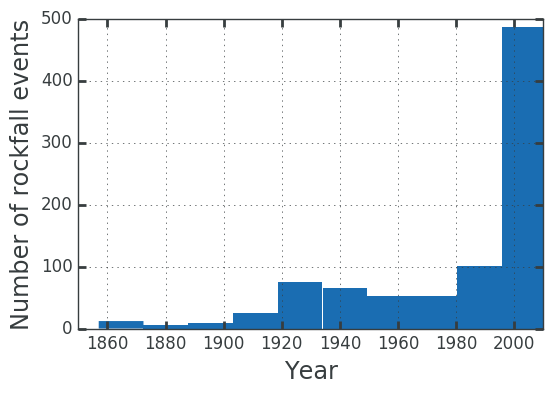

In [17]:
# OK, there are no more nuisance strings and now we have a 'Year' column which is pure integers
# Let's plot the distributions of rock-fall events as a function of year
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
df.hist(column='Year',ax=ax)
ax.set_title('')
ax.set_ylabel("Number of rockfall events")
ax.set_xlabel("Year")
ax.tick_params(labelsize=12,length=6,width=2)
ax.set_xlim(1850,2010)

So we see a large increase in the number of events in recent years. This is in large part due to reporting bias.  Monitoring of rockfall has increased since more people have been using the park and the technology to report rockfall has improved. For example, if we look at the number of visitors per year entering the park over the same time baseline, we also see a rising trend.

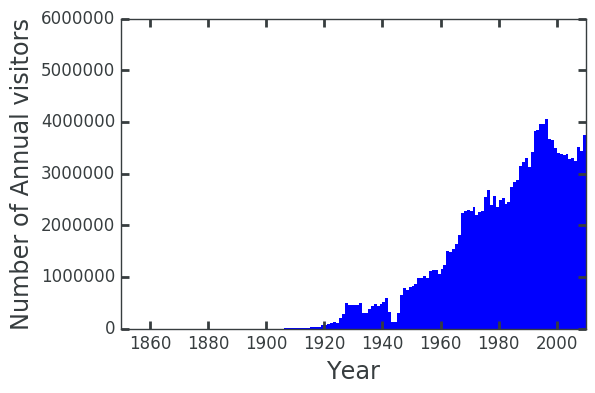

In [18]:
df_visitors = pd.read_csv(visitors_csv_file)
years_visitors = map(float,df_visitors['Year'])
N_visitors = [int(filter(str.isdigit,s)) for s in df_visitors['RecreationVisitors']]
fig,ax = plt.subplots()
ax.bar(years_visitors,N_visitors,width=1)
ax.set_xlim(1850,2010)
ax.set_title('')
ax.set_ylabel("Number of Annual visitors")
ax.set_xlabel("Year")
ax.tick_params(labelsize=12,length=6,width=2)

However, there is no reason to believe this reporting bias depends on location in the park, especially within Yosemite Valley where there are not typical road closures during the winter. So we should be ready to tackle the first question. 

## **1) Where does rock-fall most commonly take place in the park? On what formations? **

We need to gather location information. Looking at our columns, the "General location" column is a good place to start. Let's take a look at that column:

In [19]:
df['General location']

0              Taft Point
1          Yosemite Falls
2          Yosemite Falls
3           Sentinel Rock
5               Half Dome
6           Glacier Point
7             Union Point
8         Giant Staircase
9           Sentinel Rock
10          Indian Canyon
11      Illilouette Gorge
12            Union Point
13         Yosemite Falls
14         Three Brothers
15          Indian Canyon
16     Merced River Gorge
17            Union Point
18          Sentinel Rock
21          Glacier Point
22        Giant Staircase
23         Yosemite Falls
24            Union Point
26          Glacier Point
27          Glacier Point
28        Giant Staircase
29          Glacier Point
30         Yosemite Falls
31        Giant Staircase
32         Yosemite Falls
33            Wawona Road
              ...        
895          Hetch Hetchy
896        Three Brothers
897         Tenaya Canyon
898           Union Point
899       Cathedral Rocks
900        Yosemite Falls
901    Merced River Gorge
902         

How many distinct locations are reported? 

In [20]:
set(df['General location']) # lists all of the unique entries

{'Basket Dome',
 'Big Oak Flat Road',
 'Cathedral Range',
 'Cathedral Rocks',
 'Crocker Point',
 'El Capitan',
 'Giant Staircase',
 'Glacier Point',
 'Glacier Point Road',
 'Grand Canyon of Tuolumne',
 'Grizzly Peak',
 'Half Dome',
 'Hetch Hetchy',
 'Hetch Hetchy ',
 'Illilouette Gorge',
 'Indian Canyon',
 'Indian Canyon ',
 'Jack Main Canyon',
 'Little Yosemite Valley',
 'May Lake',
 'Merced River Gorge',
 'Mount Conness',
 'North Dome/Washington Column',
 'Panorama Cliff',
 'Parkwide',
 'Rancheria Mountain',
 'Rockslides',
 'Royal Arches',
 'Sentinel Rock',
 'Smedberg Lake',
 'Taft Point',
 'Tenaya Canyon',
 'Tenaya Lake',
 'Three Brothers',
 'Tioga Pass',
 'Tioga Road',
 'Tuolumne Meadows',
 'Union Point',
 'Wawona',
 'Wawona Road',
 'Wawona Road ',
 'Yosemite Falls',
 'Yosemite Valley'}

There are a bunch of different ways to figure out the most common location. A histogram won't work on this column because it is not numeric. We can get around that by assigning each of the unique locations an index. Still, a histogram of ~30 different locations is going to be ugly and hard to read. Let's do it another way, which uses masking of the dataframe to make a dictionary where the keys are the unique locations and the values are the total number of rockfall events at that location:

In [21]:
all_locations = set(df['General location'])
location_event_dict = {}
for location in all_locations:
    N_events_location = len(df[df['General location']==location]) 
    location_event_dict[location]=N_events_location

In [22]:
location_event_dict

{'Basket Dome': 17,
 'Big Oak Flat Road': 1,
 'Cathedral Range': 2,
 'Cathedral Rocks': 29,
 'Crocker Point': 5,
 'El Capitan': 36,
 'Giant Staircase': 31,
 'Glacier Point': 137,
 'Glacier Point Road': 4,
 'Grand Canyon of Tuolumne': 9,
 'Grizzly Peak': 18,
 'Half Dome': 44,
 'Hetch Hetchy': 25,
 'Hetch Hetchy ': 1,
 'Illilouette Gorge': 5,
 'Indian Canyon': 34,
 'Indian Canyon ': 1,
 'Jack Main Canyon': 2,
 'Little Yosemite Valley': 3,
 'May Lake': 1,
 'Merced River Gorge': 160,
 'Mount Conness': 1,
 'North Dome/Washington Column': 5,
 'Panorama Cliff': 16,
 'Parkwide': 2,
 'Rancheria Mountain': 2,
 'Rockslides': 24,
 'Royal Arches': 28,
 'Sentinel Rock': 33,
 'Smedberg Lake': 1,
 'Taft Point': 7,
 'Tenaya Canyon': 11,
 'Tenaya Lake': 1,
 'Three Brothers': 46,
 'Tioga Pass': 5,
 'Tioga Road': 3,
 'Tuolumne Meadows': 1,
 'Union Point': 23,
 'Wawona': 1,
 'Wawona Road': 23,
 'Wawona Road ': 1,
 'Yosemite Falls': 76,
 'Yosemite Valley': 9}

So let's make a sorted list based on the values of the dictionary

In [23]:
sorted_locations_byevent = sorted(location_event_dict.items(),key=lambda kv: kv[1])
sorted_locations_byevent

[('Hetch Hetchy ', 1),
 ('Tuolumne Meadows', 1),
 ('Wawona', 1),
 ('Wawona Road ', 1),
 ('Big Oak Flat Road', 1),
 ('Smedberg Lake', 1),
 ('Indian Canyon ', 1),
 ('May Lake', 1),
 ('Mount Conness', 1),
 ('Tenaya Lake', 1),
 ('Cathedral Range', 2),
 ('Rancheria Mountain', 2),
 ('Jack Main Canyon', 2),
 ('Parkwide', 2),
 ('Little Yosemite Valley', 3),
 ('Tioga Road', 3),
 ('Glacier Point Road', 4),
 ('Tioga Pass', 5),
 ('Crocker Point', 5),
 ('Illilouette Gorge', 5),
 ('North Dome/Washington Column', 5),
 ('Taft Point', 7),
 ('Grand Canyon of Tuolumne', 9),
 ('Yosemite Valley', 9),
 ('Tenaya Canyon', 11),
 ('Panorama Cliff', 16),
 ('Basket Dome', 17),
 ('Grizzly Peak', 18),
 ('Wawona Road', 23),
 ('Union Point', 23),
 ('Rockslides', 24),
 ('Hetch Hetchy', 25),
 ('Royal Arches', 28),
 ('Cathedral Rocks', 29),
 ('Giant Staircase', 31),
 ('Sentinel Rock', 33),
 ('Indian Canyon', 34),
 ('El Capitan', 36),
 ('Half Dome', 44),
 ('Three Brothers', 46),
 ('Yosemite Falls', 76),
 ('Glacier Point'

So here we see that the top 5 locations with the all-time highest total number of rock-falls:
1. Merced River Gorge
2. Glacier Point
3. Yosemite Falls
4. Three Brothers
5. Half Dome

Interestingly, the two locations that I anecdotally have heard feature lots of rockfall are Glacier Point and Half Dome, and both make the top 5 list. While the face of Half Dome (as opposed to the rounded backside) is not frequented by hikers, it is the home of many iconic and historic rock climbs that are busy during peak climbing season. Glacier point in particular is worrying as it towers above most of the camping in the park and features many popular rock climbs. 

El Capitan is not in the top 5 (it is #6), despite making the news with the very large rockfall in September 2017. 

This does not necessarily mean that these places are *currently* the most risky to visit as we don't have the data from the last 8 years. However, what if we ask the same question but see how it evolves with time? This is question 2:

## **2) Are any formations experiencing significant increases or decreases in rockfall activity in the last 10 years (of the available data)? **

To answer this, we add a loop in which we make sub-dataframes based on date range. And this time I will rank locations based on the fraction of total events in a given time interval. This will make it easier to compare at the end.

In [24]:
delta_year = 10 # gap between years 
year_bins = np.arange(1850,2010,delta_year)

master_event_dict = {}
for begin_year in year_bins:
    end_year = begin_year + delta_year
    decade_str = '%i-%i' % (begin_year,end_year)
    mask = np.logical_and(df['Year']>=begin_year,df['Year']<end_year)
    df_daterange = df[mask]
    N_tot_daterange = len(df_daterange) # Number of total events in this date range
    # Now make the location event dictionary for this date range
    location_event_dict = {} # Will keep track of number of events 
    for location in all_locations:
        N_events_location = len(df_daterange[df_daterange['General location']==location])
        location_event_dict[location]=N_events_location

    # Now rank the locations based on fraction of total events within this date range 
    sorted_location_dict = {x[0]:x[1] for x in sorted(location_event_dict.items(),key=lambda kv: kv[1])}
    master_event_dict[decade_str] = sorted_location_dict
    

Now let's choose a few of the most common rockfall locations of all time we found above and plot the fraction over time 

In [25]:
toplocations=['Merced River Gorge','Glacier Point','Yosemite Falls','Three Brothers','Half Dome','El Capitan']
fracs_dict = {} # will keep track of the fractions and Poisson error on fractions 
# as a function of date for top  locations
for begin_year in year_bins:
    end_year = begin_year + delta_year
    decade_str = '%i-%i' % (begin_year,end_year)
    sorted_locations_dict = master_event_dict[decade_str]
    for location in toplocations:
        N_event = sorted_locations_dict[location]
        N_tot_decade = np.sum(sorted_locations_dict.values())
        frac = N_event/float(N_tot_decade)
        frac_err = np.sqrt(N_event)/N_tot_decade # Poisson error
        try:
            fracs_dict[location].append((frac,frac_err))
        except:
            fracs_dict[location] = [(frac,frac_err)]
    

(-0.05, 0.7)

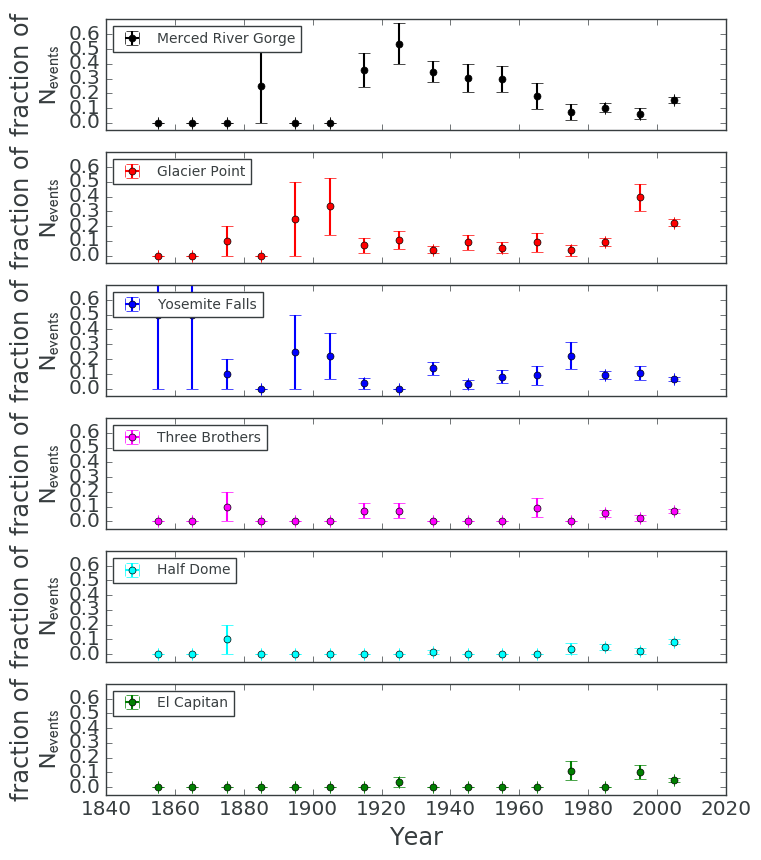

In [268]:
# Now plot the fractions versus time for the 5 locations
year_cens = year_bins + delta_year/2.
fig,axes=plt.subplots(nrows=len(fracs_dict),ncols=1,sharex=True,sharey=True,figsize=(8,10))
colors=['k','r','b','magenta','cyan','g']
for ii,location in enumerate(toplocations):
    ax = axes[ii]
    frac_tuple_list = fracs_dict[location]
    fracs,fracerrs = zip(*frac_tuple_list)
    ax.errorbar(year_cens,fracs,xerr=0,yerr=fracerrs,color=colors[ii],linestyle='',marker='o',
                markersize=5,capsize=4,label=location)
    ax.legend(fontsize=10,loc=2)
    ax.set_ylabel("fraction of\n" + r"$\mathrm{N_{events}}$")
ax.set_xlabel('Year')
ax.set_ylim(-0.05,0.7)

Interestingly, it looks like Merced River Gorge was very active in the past, but less so in the last few decades.  Half Dome has the largest uptick in fraction of rockfall events since 2000, with the Three Brothers also showing an increase. Overall, Glacier Point produces the largest fraction of current (as of ~2000-2010) rockfall events at around 25% of all recorded rockfalls in the park. To get an idea of how many rockfall events per year that this actually corresponds to, we need to know the total number of rockfall events in that time interval. We can easily calculate that from our events dictionary:

In [269]:
latest_event_dict = master_event_dict['2000-2010']
N_events_latest_perdecade = np.sum(latest_event_dict.values())
N_events_latest_peryear = N_events_latest_perdecade/10.
N_events_GP_peryear = N_events_latest_peryear*0.25
print N_events_GP_peryear

8.025


So there were ~8 documented rockfall events per year in Glacier Point in the decade 2000-2010. So assuming these happen uniformly throughout the year, there is at least a 2 percent chance on any given day that a rockfall event will occur. It is "at least 2 percent" because inevitably some rockfall events are missed (up to 50% in some areas; G. Stock, private communication). While 2 percent seems low, it is not neglibable for someone planning to climb these walls, especially if that climb takes place over multiple days.

Now a big assumption of the above statistic was that rockfall events happen uniformly throughout the year. This raises question #3: 

## **3) Does rock-fall take place preferentially in some seasons? **

The research that has been done on Yosemite rockfall (e.g https://pubs.usgs.gov/ds/746/ds746_text.pdf) shows that some of the main causes are likely connected to precipitation. One of these mechanisms is called "frost wedging". This is a process where water enters a crack and then freezes. When water freezes it expands, which exerts a outward force on the walls of the crack. Over time, this can push loose rock features toward the surface until they eventually succumb to gravity. If frost wedging is a primary cause of rockfall, then we would expect the winter and spring to account for the highest numbers of rockfalls.

A straightforward way to assess this hypothesis is by comparing numbers of rockfall in dry seasons (Summer, Fall) versus the wetter seasons (Winter, Spring). If rockfall events are more frequent in the wetter seasons, then we have potential evidence of the frost-wedging phenomenon, although of course it is not the only possible explanation. 

# Season, N_events, uncertainty:
Winter 247 15.72
Spring 250 15.81
Summer 171 13.08
Fall 199 14.11


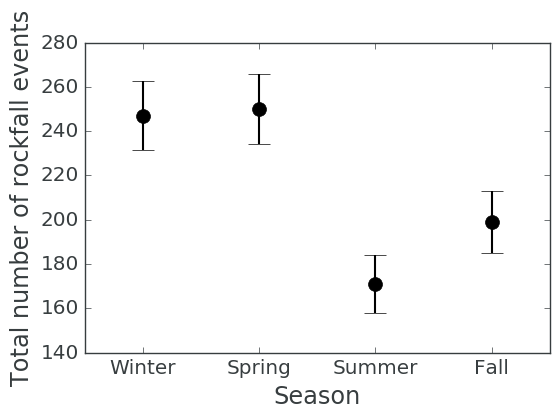

In [270]:
fig,ax=plt.subplots()
seasons = ['Winter','Spring','Summer','Fall']
events_per_season = []
print "# Season, N_events, uncertainty:"
for season in seasons:
    df_season = df[df['Season']==season]
    N_events = len(df_season)
    events_per_season.append(N_events)
    print "%s %i %.2f" % (season, N_events, np.sqrt(N_events))
events_per_season = np.array(events_per_season)
unc_events_per_season = np.sqrt(events_per_season) # Poisson errors
ax.errorbar([1,2,3,4],events_per_season,yerr=unc_events_per_season,color='k',linestyle='',marker='o', markersize=10,capsize=8)
ax.set_xlim(0.5,4.5)
ax.set_xticks([1,2,3,4])
ax.set_xticklabels(seasons)
ax.set_xlabel('Season')
ax.set_ylabel('Total number of rockfall events')

This shows that rockfall is in fact more common in the wetter seasons (Winter/Spring) than the drier seasons. This is evidence in support of precipitation being at least partially responsible for rockfall. We can turn this into a statistical statement by performing a Pearson's chi-square test with hypotheses:

- $H_0$ (Null hypothesis): Rockfall occurs at the same rate during wet seasons (Winter/Spring) as dry seasons (Summer,Fall)
- $H_A$ (Alternative hypothesis): Rockfall does not occur at the same rate during wet and dry seasons

We will reject the null hypothesis if our p-value is $<0.05$, i.e. $>95\%$ confidence.

As we saw above, we have:
- 497 rockfall events that took place during the wet seasons (Winter/Spring)
- 370 rockfall events that took place during the dry seasons (Summer/Fall)

Under the null hypothesis, the expected number of rockfall events during either season is 50% of the total number of rockfall events. The total is $497+370=867$ events, so we would expect $867/2 = 433.5$ events. Let us now calculate the $\chi^2$. Generally,

$$\chi^2 = \sum_i^N\frac{(\mathrm{Observed_i} - \mathrm{Expected_i})^2}{\mathrm{Expected_i}},$$
where $\mathrm{Observed_i}$, and $\mathrm{Expected_i}$ are the numbers of observed and expected counts, respectively in a given category. The sum is over the categories. 

In our case, we have 2 categories: wet and dry, so our $\chi^2$ is:
$$\chi^2 = \frac{(497 - 433.5)^2}{433.5} + \frac{(370 - 433.5)^2}{433.5} = 18.6$$

To assess the significance of this finding, we compare this value to the value of the $\chi^2$ function at the critical value that corresponds to p-value of $0.05$ (i.e. where the cumulative distribution function=0.95). We note that we have a single degree of freedom, $\nu$, here because $\nu = N-1$, where N is the number of categories which is 2 in our case. Therefore we reference the $\nu=1$ $\chi^2$ distribution. A table of values can be found here: https://www.itl.nist.gov/div898/handbook/eda/section3/eda3674.htm

We see that for the $\chi^2_{\nu=1}$ distribution, a p-value of $0.05$ corresponds to a $\chi^2=3.841$. The value we found was $18.6$, so we reject the null hypothesis with $>95\%$ confidence. So whatever the cause, rockfall events occur more commonly in the wetter seasons, which might be evidence for the frost wedging phenomenon put forward by park geologists. 

I'll note that rockfall events that take place during the winter and spring are less likely to be reported due to the fact that there are fewer guests in the park. Here are some numbers on the visitors to Yosemite in each month of the year, for all years since 1979.

In [216]:
df_monthly = pd.read_csv(visitors_montly_csv_file)
df_monthly.head(50)

,Year,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,Total
0,2018,"129,432","143,321","170,681","278,349","385,670","543,690","504,230","441,867","524,387","360,776","215,854","311,179","4,009,436"
1,2017,"120,025","119,421","166,793","302,553","471,844","565,702","633,351","615,892","566,279","429,827","217,927","127,276","4,336,890"
2,2016,"139,780","201,601","286,990","305,092","457,309","703,614","780,728","692,450","598,428","483,232","218,998","160,646","5,028,868"
3,2015,"128,318","135,316","194,667","281,328","408,121","545,231","626,009","636,936","527,402","357,223","169,425","140,241","4,150,217"
4,2014,"112,133","113,403","146,750","242,722","333,308","496,363","623,663","654,157","467,205","354,769","203,678","134,491","3,882,642"
5,2013,"103,910","114,440","165,409","231,178","370,422","508,941","611,538","552,137","460,855","279,526","161,356","131,479","3,691,191"
6,2012,"120,496","113,341","136,687","243,102","356,500","528,186","623,101","660,118","482,004","322,687","141,868","125,314","3,853,404"
7,2011,"100,718","93,588","100,433","231,372","356,588","503,741","704,553","699,749","533,502","360,449","139,079","127,621","3,951,393"
8,2010,"96,089","100,379","149,651","224,461","382,414","521,059","643,566","659,857","520,210","356,370","148,459","98,893","3,901,408"
9,2009,"101,984","78,795","132,711","230,828","399,683","483,382","586,591","643,300","471,530","346,826","151,297","110,545","3,737,472"


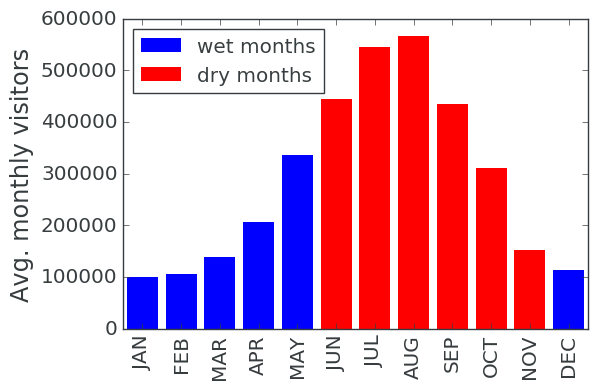

In [246]:
# Let's visualize the montly averages:
month_columns = df_monthly.columns[1:-1]
fig,ax=plt.subplots()
avg_visitors_list = []
for month in month_columns:
    monthly_visitors = df_monthly[month]
    monthly_visitors = np.array([float(filter(str.isdigit,n)) for n in monthly_visitors])
    avg_visitors     = np.mean(monthly_visitors)
    avg_visitors_list.append(avg_visitors)

colors=['b','b','b','b','b','r','r','r','r','r','r','b']
ax.bar(range(12),avg_visitors_list,align='center',width=0.8,color=colors)
ax.set_xticks(range(12),)
ax.set_xticklabels(month_columns,rotation='vertical')
ax.bar(-10,30000,color='b',label='wet months')
ax.bar(-10,30000,color='r',label='dry months')
ax.set_xlim(-0.5,11.5)
ax.set_ylabel('Avg. monthly visitors')
ax.legend(loc=2)

The more eyes and ears in the park, the greater the chance that a rockfall event will be reported. So the fact that rockfall events are *still* more frequent in the wetter seasons is remarkable. As a result, the discrepancy between rockfall events in wetter months vs. drier months is probably larger than the data suggest.

The fact that rockfall is more likely to occur during these wetter, colder months is actually quite fortunate because it means fewer people are at risk of being struck by the falling debris. After all, maybe this is the answer to why rockfall deaths are uncommon in Yosemite. 